# SNR proof of concept
based on toolbox_games/Utils/OnTheFly.py

In [ ]:
from scipy.io import loadmat
import numpy as np

# opcode 8 - no protection
# opcode 18, 19 - random / dual rail
# opcode 0,1 - minimal protection
# add more samples... (V)
# change start index to 200
path = 'Z:\\Onion\\OpCode_8ExpMode_1ClkDiv_3_V2'
mat = loadmat(path+'\\traces_100.mat')
traces = mat['traces'][:,200:500]
plaintexts = mat['plaintext']
keys = mat['key']
for i in range(101, 1001):
    mat = loadmat(path+'\\traces_'+str(i)+'.mat')
    traces = np.append(traces, mat['traces'][:,200:500], axis=0)
    plaintexts = np.append(plaintexts, mat['plaintext'], axis=0)
    keys = np.append(keys, mat['key'], axis=0)

SAMPLES = np.shape(traces)[1]
Queries = np.shape(traces)[0]

print(np.shape(traces))


calculate Y[0] (one byte) of each sample

In [14]:

from tool_box_games.Utils.sboxes import sbox_aes as sbox
Y = np.zeros(Queries,dtype=np.uint8)
for i in range(0, SAMPLES):
    Y[i] = sbox[np.bitwise_xor(plaintexts[i][0], keys[i][0])]

now implementing SNR...
<br>
Denote: $y=Sbox\left(x\oplus k\right)$,
<br>
SNR(t) = $\frac{Var_y(E_i(l_y^i(t)))}{E_y(Var_i(l_y^i(t)))}$

In [15]:
# X = traces matrix
# Y = class of each query, here it's the sbox result
# N_classes = length of Y
# N_samples = num. of samples
# type = data type
def SNR(X, Y, N_classes, N_samples, type=np.float32):
    # initialize...
    count_on_y = np.zeros((N_classes),dtype=type)
    _sum = np.zeros((N_classes,N_samples),dtype=type)
    sum_squares = np.zeros((N_classes,N_samples),dtype=type)
    means = np.zeros((N_classes,N_samples),dtype=type)
    _vars = np.zeros((N_classes,N_samples),dtype=type)
    means[:,:] = np.nan
    SNR = np.zeros(N_samples,dtype=type)
    
    # for all unique elements in the Y's, compute the mean and the variance:
    for y in np.unique(Y%N_classes):
        indexes = np.where((Y%N_classes)==y)[0]
        count_on_y[y] += len(indexes)
        # sum the different leakages for y
        _sum[y,:] += np.sum(X[indexes,:],axis=0)
        # sum the squares
        sum_squares[y,:] += np.sum(X[indexes,:]**2,axis=0)
        # calc mean, var assuming uniform distribution
        means[y,:] = _sum[y,:] / count_on_y[y]
        _vars[y,:] = (sum_squares[y,:]/count_on_y[y]) - (means[y,:]**2)
    SNR[:] =  np.nanvar(means,axis=0)/np.mean(_vars,axis=0)
    return SNR

# wrapper function: split traces by time (parameter to divide)
def SNR_wrapper(X, Y, N_classes, N_samples, type=np.float32, frames=100):
    frame_len = int(np.shape(X)[1] / frames)
    snr_t = SNR(X[:,0:frame_len], Y, N_classes, frame_len, type)
    for frame in range(1, frames):
        snr_t = np.append(snr_t, SNR(X[:,frame_len*frame:frame_len*(frame+1)], Y, N_classes, frame_len, type))
    return snr_t

Plotting results...

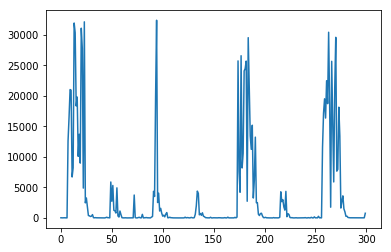

In [17]:
from matplotlib.pyplot import plot
snr_t = SNR(traces, Y, 256, SAMPLES, np.int16)
plot(range(0, SAMPLES), np.abs(snr_t))

builtin implementation:

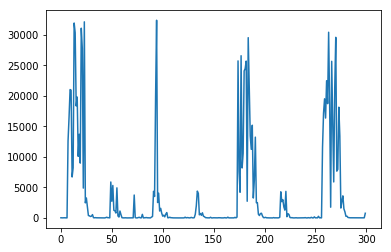

In [18]:
from tool_box_games.Utils.OnTheFly import SNR as t_SNR
s = t_SNR(256, SAMPLES, np.int16)
plot(range(0, SAMPLES), np.abs(s.fit(traces, Y)))